In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import sys
sys.path.append("../../../")
import src

from src.core.control import AfPrecisionControl
from src.core.control import CoupledStorageConfig

from src.core.dimensionless import WavevectorScale

from src.core.media import TwoBeamPhotorefractiveCrystal
from src.core.eq_coefs import CoupledPhotorefractiveCoefs
from src.core.mesh import Mesh2D
from src.core.beams import TwoBeams

from src.fields import NotebookAfCoupledSimulation2D
from src.fields import LatticeGaussianCoupledConfig

from src.fields.landscapes.lattices.moire_lattices import double_square
from src.simulators.nls_2d.coupled_eqs.split_step import split_step_solver

from src.simulators.nls_2d.coupled_eqs import CoupledSimulationBox

In [3]:
store_config = CoupledStorageConfig(directory = "./Data/Last/",
                                    store = "last",
                                    extension = ".h5",
                                    )

# Precision Control

In [4]:
precision = "double"

precision_control = AfPrecisionControl(precision=precision,
                                       store_config=store_config,
                                       )

# Crystal Parameters

In [5]:
crystal_parameters = TwoBeamPhotorefractiveCrystal(n = 2.36,
                                                   n1 = 2.36,
                                                   electro_optic_coef = 235e-12,
                                                   electro_optic_coef1 = 235e-12,
                                                   tension = 400,
                                                   Isat = 100,
                                                   alpha = 0.,
                                                   alpha1 = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   store_config=store_config,
                                                   )

# Beam Parameters

In [6]:
beam_parameters = TwoBeams(wavelengths = (532e-9, 633e-9),
                             cs = (-1., 0),
                             store_config = store_config,
                             )

# Init adimensionalization method

In [7]:
adim_method = WavevectorScale(beam_parameters, crystal_parameters, precision_control)

# Init solving method

In [8]:
solver = split_step_solver

# Init Eqs. Coefficients

In [9]:
coefs = CoupledPhotorefractiveCoefs(crystal_parameters,
                                    beam_parameters,
                                    adim_method,
                                    store_config,
                                    )

coefs.print_coefs()

Kinetic: 0.5000000000000001, Potential: -0.9999999999999999, Absorption: 0.0
Kinetic1: 0.5949248120300752, Potential1: 0.0, Absorption1: 0.0


# Start Simulation Object

In [10]:
import arrayfire as af

def print_available_devices():
    device_count = af.get_device_count()
    print("Total available devices:", device_count)
    for dev in range(device_count):
        af.set_device(dev)
        print(f"Device {dev}:")
        print(af.device_info())
        print("-" * 40)

print_available_devices()


Total available devices: 1
Device 0:
{'device': 'NVIDIA_TITAN_V', 'backend': 'CUDA', 'toolkit': 'v12.2', 'compute': '7.0'}
----------------------------------------


In [11]:
simulation_config = {"Nx": 1024,
                     "Ny": 1024,
                     "Nz": 200,
                     "lx": 2e-3,
                     "ly": 2e-3,
                     "lz": 100e-3,
                     }

mesh = Mesh2D(simulation_config, adim_method)

SimBox = CoupledSimulationBox(mesh=mesh,
                              coefs=coefs,
                              solver_method=solver,
                              precision_control=precision_control,
                              device=0,
                              gpu_backend="cuda",
                              )

# Configure Modulation

In [12]:
theta = np.atan(3/4)
theta = np.atan(1/np.sqrt(3))
eta = .5*(.5*np.pi - theta)

modulation_properties = LatticeGaussianCoupledConfig(lattice_parameter=None,
                                                lattice1_parameter=(np.sqrt(2)*50e-6, np.sqrt(2)*50e-6),
                                                p=None,
                                                p1=(1., .4),
                                                rotation=None,
                                                rotation1=(eta, theta+eta),
                                                width=(11e-6, 11e-6),
                                                width1=(400e-6, 400e-6),
                                                I=1.,
                                                I1=100.,
                                                power=1.,
                                                power1=4.,
                                                store_config=store_config,
                                                lattice_method=None,
                                                lattice1_method=double_square,
                                                )

Lattice parameters on the first beam are not defined.


# Create Input Fields

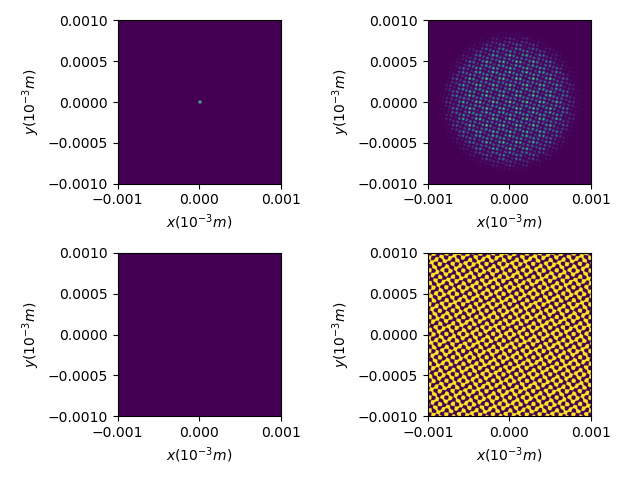

In [13]:
input_fields = NotebookAfCoupledSimulation2D(simulation_config,
                           modulation_config=modulation_properties,
                           precision_control=precision_control,
                           store_config=store_config,
                           )

input_fields.gen_fields(mesh,)

input_fields.plot_fields()

# Run Solver

In [14]:
output_fields = SimBox.solver(input_fields, store_config=store_config, return_flag=True)

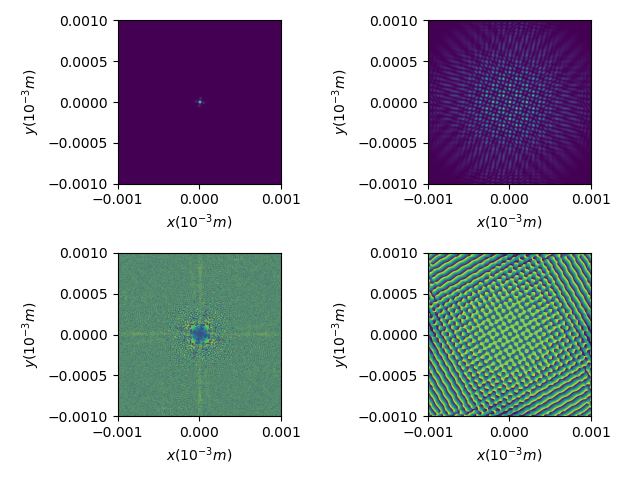

In [15]:
output_fields.plot_fields()